# Airbnb Price Prediction – XGBoost vs Neural Networks

This notebook implements my solution for **Assignment 4 – Bakeoff!** in EAS 510 (Basics of AI).

The goal is to **predict Airbnb listing prices** and compare two model families:

- A **tree-based gradient boosting model (XGBoost)**  
- **Fully-connected neural networks (Dense MLPs)**

I use data from the **Inside Airbnb** project for **12 cities**, grouped into three market tiers:

- **Big:** New York City, Los Angeles, San Francisco, Chicago  
- **Medium:** Austin, Seattle, Denver, Portland  
- **Small:** Asheville, Santa Cruz, Salem, Columbus  

For each city I downloaded the `listings.csv` file from Inside Airbnb (for a specific month/year in 2025) and built a **single, reusable preprocessing pipeline** that can be applied across all cities and tiers.

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import shap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import re
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

## Data sources

All raw data come from the public **Inside Airbnb** dataset.

For each city, I downloaded the `listings.csv` file from the “Get the Data” page corresponding to a particular **month and year in 2025**. The files are stored in a structured directory:

- `data/<city_short_name>/listings-<city>-YYYY-MM.csv`

In the README I summarize the datasets in a table with the following columns:

- **City** – human-readable name (e.g., “New York City”)  
- **Tier** – `Big`, `Medium`, or `Small`  
- **Data Month** – month/year as shown on the Inside Airbnb website  
- **Listings Count** – number of rows in `listings.csv` before any cleaning

This makes it clear **where my data came from** and how to **reproduce** the exact same experiments later.

In [104]:
CITY_CONFIG = {
    "nyc": {
        "pretty_name": "New York City",
        "tier": "big",
        "path": "../data/nyc/listings-nyc-2025-10.csv"
    },
    "la": {
        "pretty_name": "Los Angeles",
        "tier": "big",
        "path": "../data/la/listings-la-2025-09.csv"
    },
    "sf": {
        "pretty_name": "San Francisco",
        "tier": "big",
        "path": "../data/sf/listings-sf-2025-09.csv"
    },
    "chi": {
        "pretty_name": "Chicago",
        "tier": "big",
        "path": "../data/chi/listings-chi-2025-06.csv"
    },

    "aus": {
        "pretty_name": "Austin",
        "tier": "medium",
        "path": "../data/aus/listings-aus-2025-06.csv"
    },
    "sea": {
        "pretty_name": "Seattle",
        "tier": "medium",
        "path": "../data/sea/listings-sea-2025-09.csv"
    },
    "den": {
        "pretty_name": "Denver",
        "tier": "medium",
        "path": "../data/den/listings-den-2025-09.csv"
    },
    "por": {
        "pretty_name": "Portland",
        "tier": "medium",
        "path": "../data/por/listings-por-2025-09.csv"
    },

    "ash": {
        "pretty_name": "Asheville",
        "tier": "small",
        "path": "../data/ash/listings-ash-2025-06.csv"
    },
    "sc": {
        "pretty_name": "Santa Cruz",
        "tier": "small",
        "path": "../data/sc/listings-sc-2025-06.csv"
    },
    "sal": {
        "pretty_name": "Salem",
        "tier": "small",
        "path": "../data/sal/listings-sal-2025-09.csv"
    },
    "col": {
        "pretty_name": "Columbus",
        "tier": "small",
        "path": "../data/col/listings-col-2025-09.csv"
    },
}

TIERS = {
    "big":   ["nyc", "la", "sf", "chi"],
    "medium": ["aus", "sea", "den", "por"],
    "small": ["ash", "sc", "sal", "col"],
}


## Feature engineering

The original `listings.csv` files contain many columns. For this assignment, I focused on the **numeric features requested in the prompt** plus several additional engineered features.

### Base numeric features

These are taken directly (or lightly cleaned) from the dataset:

- `accommodates`
- `bedrooms`
- `beds`
- `bathrooms_text` → parsed into numeric `bathrooms_num`
- `review_scores_rating`
- `review_scores_accuracy`
- `review_scores_cleanliness`
- `review_scores_checkin`
- `review_scores_communication`
- `review_scores_location`
- `review_scores_value`
- `number_of_reviews`
- `availability_365`
- `minimum_nights`
- `maximum_nights`

The **target variable** is:

- `price` – cleaned from strings like `$1,234.00` into float and used **only** as the label, not as a feature.

### Additional engineered features (at least 4, I used 5)

To better capture price drivers, I created the following features and used them consistently across all cities:

1. **`accommodates_per_bedroom`**  
   - Definition: `accommodates / bedrooms`  
   - Intuition: higher values mean more guests per bedroom, which can indicate denser/cheaper properties vs. spacious units.

2. **`accommodates_per_bed`**  
   - Definition: `accommodates / beds`  
   - Intuition: similar idea but based on beds; can differentiate listings with many beds crammed into few rooms.

3. **`avg_review_score`**  
   - Definition: mean of all `review_scores_*` columns  
   - Intuition: a single aggregate quality score; higher values generally allow hosts to charge more.

4. **`amenities_count`**  
   - Definition: count of the number of amenities listed for each property  
   - Intuition: listings with more amenities (Wi-Fi, parking, kitchen, etc.) are often more expensive.

5. **`is_entire_home`**  
   - Definition: binary indicator (1 if `room_type == "Entire home/apt"`, else 0)  
   - Intuition: entire homes/apartments are usually more expensive than private/shared rooms.

### Handling missing values

- All numeric features are coerced to floats.  
- Missing values in the feature matrix are imputed using **median values computed per column**.  
- Rows with **missing or non-positive price** are dropped, since they cannot be used as training labels.

This gives me a **consistent numeric feature matrix** for all 12 cities, which is crucial for building shared tier-level models.

In [105]:

BASE_NUMERIC_COLUMNS = [
    "accommodates",
    "bedrooms",
    "beds",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "number_of_reviews",
    "availability_365",
    "minimum_nights",
    "maximum_nights",
]

BATHROOMS_NUM_COL = "bathrooms_num"

ENGINEERED_FEATURES = [
    "accommodates_per_bedroom",
    "accommodates_per_bed",      
    "avg_review_score",          
    "amenities_count",           
    "is_entire_home",            
]

In [106]:

ALL_FEATURE_COLUMNS = BASE_NUMERIC_COLUMNS + [BATHROOMS_NUM_COL] + ENGINEERED_FEATURES

TARGET_COL = "price"


In [107]:
def parse_price(price_str):
    """Convert price string like '$1,234.00' to float."""
    if pd.isna(price_str):
        return np.nan
    s = str(price_str)
    s = re.sub(r"[\$,]", "", s)
    try:
        return float(s)
    except ValueError:
        return np.nan


In [108]:
def parse_bathrooms(bath_str):
    """Extract numeric bathrooms from '1 bath', '1.5 shared baths', etc."""
    if pd.isna(bath_str):
        return np.nan
    s = str(bath_str)
    match = re.findall(r"\d+\.?\d*", s)
    if match:
        return float(match[0])
    return np.nan


In [109]:
def safe_divide(num, den):
    return num / (den.replace(0, np.nan)) 

In [110]:
def ensure_columns(df, cols):
    """Ensure all required columns exist, create missing as NaN."""
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    return df


In [111]:
def load_and_preprocess_city(city_key, config):
    """
    Load listings.csv for a given city, clean target & features, and
    return (X, y, listing_count).
    """
    path = config["path"]
    print(f"Loading city {config['pretty_name']} from {path}")
    df = pd.read_csv(path, low_memory=False)

    listing_count = len(df)

    df[TARGET_COL] = df[TARGET_COL].apply(parse_price)
    df = df.dropna(subset=[TARGET_COL])
    df = df[df[TARGET_COL] > 0]

    if "bathrooms_text" in df.columns:
        df[BATHROOMS_NUM_COL] = df["bathrooms_text"].apply(parse_bathrooms)
    else:
        df[BATHROOMS_NUM_COL] = np.nan

    df = ensure_columns(df, BASE_NUMERIC_COLUMNS)

    df["accommodates_per_bedroom"] = df["accommodates"] / (df["bedrooms"].replace(0, np.nan))


    df["accommodates_per_bed"] = df["accommodates"] / (df["beds"].replace(0, np.nan))


    review_cols = [
        "review_scores_rating",
        "review_scores_accuracy",
        "review_scores_cleanliness",
        "review_scores_checkin",
        "review_scores_communication",
        "review_scores_location",
        "review_scores_value",
    ]
    df["avg_review_score"] = df[review_cols].mean(axis=1)

    if "amenities" in df.columns:
        df["amenities_count"] = df["amenities"].astype(str).apply(
            lambda x: len(re.findall(r"'", x)) // 2 if ("{" in x or "[" in x) else len(x.split(","))
        )
    else:
        df["amenities_count"] = np.nan

    if "room_type" in df.columns:
        df["is_entire_home"] = (df["room_type"] == "Entire home/apt").astype(int)
    else:
        df["is_entire_home"] = 0

    df = ensure_columns(df, ALL_FEATURE_COLUMNS)

    X = df[ALL_FEATURE_COLUMNS].copy()
    y = df[TARGET_COL].copy()

    X = X.apply(pd.to_numeric, errors="coerce")
    X = X.fillna(X.median())

    return X, y, listing_count


## Models and training strategy

I compare two model families:

1. **XGBoost Regressor (tree-based)**  
2. **Neural Networks (fully-connected MLPs)**

### XGBoost

- Implemented with `xgboost.XGBRegressor`.
- Key hyperparameters (fixed across tiers for fairness):
  - `n_estimators = 300`
  - `learning_rate = 0.05`
  - `max_depth = 6`
  - `subsample = 0.8`
  - `colsample_bytree = 0.8`
- Trained **at the tier level**: for each tier (big, medium, small), I concatenate all cities in that tier and train one model on the combined dataset.

### Neural networks

I build two different Dense MLP architectures using **Keras**:

- **Model A:**  
  - Layers: `[64, 32]` with ReLU activations  
  - Output: single linear neuron for price

- **Model B:**  
  - Layers: `[128, 64, 32]` with ReLU activations  
  - Output: single linear neuron

For each tier:

- I standardize features using `StandardScaler`.  
- I train both models with:
  - Loss: Mean Squared Error (MSE)  
  - Optimizer: Adam  
  - Early stopping on validation loss (`patience=5`, `restore_best_weights=True`)  
- I select the **better architecture per tier** based on validation RMSE and treat that as the **tier’s NN model**.

### Train/test strategy

- For each tier, I create a **train/test split** on the combined tier data with `test_size=0.2` and a fixed random seed.  
- I also keep track of **which city each row belongs to**, so I can later compute **per-city metrics** from the tier models without leaking information.

Evaluation metrics:

- **RMSE (Root Mean Squared Error)**  
- **MAE (Mean Absolute Error)**  
- **R² (coefficient of determination)**

These metrics are reported at both the **tier level** and the **city level**.


In [112]:
city_features = {}
city_targets = {}
city_listing_counts = {}
city_tiers = {}

for ck, cfg in CITY_CONFIG.items():
    X, y, listing_count = load_and_preprocess_city(ck, cfg)
    city_features[ck] = X
    city_targets[ck] = y
    city_listing_counts[ck] = listing_count
    city_tiers[ck] = cfg["tier"]

all_cols = sorted(set().union(*[df.columns for df in city_features.values()]))

for ck in city_features:
    city_features[ck] = city_features[ck].reindex(columns=all_cols, fill_value=0)

n_features = len(all_cols)
print(f"\nTotal number of feature columns: {n_features}")
print("Example feature columns:", all_cols[:10], "...")



Loading city New York City from ../data/nyc/listings-nyc-2025-10.csv
Loading city Los Angeles from ../data/la/listings-la-2025-09.csv
Loading city San Francisco from ../data/sf/listings-sf-2025-09.csv
Loading city Chicago from ../data/chi/listings-chi-2025-06.csv
Loading city Austin from ../data/aus/listings-aus-2025-06.csv
Loading city Seattle from ../data/sea/listings-sea-2025-09.csv
Loading city Denver from ../data/den/listings-den-2025-09.csv
Loading city Portland from ../data/por/listings-por-2025-09.csv
Loading city Asheville from ../data/ash/listings-ash-2025-06.csv
Loading city Santa Cruz from ../data/sc/listings-sc-2025-06.csv
Loading city Salem from ../data/sal/listings-sal-2025-09.csv
Loading city Columbus from ../data/col/listings-col-2025-09.csv

Total number of feature columns: 20
Example feature columns: ['accommodates', 'accommodates_per_bed', 'accommodates_per_bedroom', 'amenities_count', 'availability_365', 'avg_review_score', 'bathrooms_num', 'bedrooms', 'beds', 'is_

In [113]:
tier_data = {}

for tier_name, cities in TIERS.items():
    X_list, y_list, city_label_list = [], [], []

    for ck in cities:
        X_city = city_features[ck]
        y_city = city_targets[ck]
        labels = np.array([ck] * len(X_city))

        X_list.append(X_city)
        y_list.append(y_city)
        city_label_list.append(labels)

    X_tier = pd.concat(X_list, axis=0, ignore_index=True)
    y_tier = pd.concat(y_list, axis=0, ignore_index=True)
    city_labels = np.concatenate(city_label_list, axis=0)

    X_train, X_test, y_train, y_test, city_train, city_test = train_test_split(
        X_tier, y_tier, city_labels,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=city_labels
    )

    tier_data[tier_name] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "city_train": city_train,
        "city_test": city_test,
    }

    print(f"Tier {tier_name}: train={len(X_train)}, test={len(X_test)} rows")

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2



Tier big: train=57298, test=14325 rows
Tier medium: train=20022, test=5006 rows
Tier small: train=5650, test=1413 rows


In [114]:
tier_xgb_models = {}
tier_xgb_results = []

for tier_name, data in tier_data.items():
    print(f"\nTraining XGBoost for tier: {tier_name}")
    X_train = data["X_train"]
    X_test = data["X_test"]
    y_train = data["y_train"]
    y_test = data["y_test"]
    city_test = data["city_test"]

    xgb_model = xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    xgb_model.fit(X_train, y_train)
    tier_xgb_models[tier_name] = xgb_model

    y_pred_test = xgb_model.predict(X_test)
    rmse, mae, r2 = compute_metrics(y_test, y_pred_test)
    tier_xgb_results.append({
        "tier": tier_name,
        "city": "overall tier",
        "model": "XGBoost",
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })


    print(f"  Tier overall - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")

    for city_key in TIERS[tier_name]:
        mask = (city_test == city_key)
        if mask.sum() == 0:
            continue
        rmse_c, mae_c, r2_c = compute_metrics(y_test[mask], y_pred_test[mask])
        tier_xgb_results.append({
            "tier": tier_name,
            "city": city_key,
            "model": "XGBoost",
            "RMSE": rmse_c,
            "MAE": mae_c,
            "R2": r2_c
        })

tier_xgb_results_df = pd.DataFrame(tier_xgb_results)
tier_xgb_results_df.head()


Training XGBoost for tier: big
  Tier overall - RMSE: 2711.67, MAE: 513.98, R2: 0.272

Training XGBoost for tier: medium
  Tier overall - RMSE: 2371.83, MAE: 392.33, R2: 0.464

Training XGBoost for tier: small
  Tier overall - RMSE: 2483.89, MAE: 355.45, R2: -0.161


,tier,city,model,RMSE,MAE,R2
0,big,overall tier,XGBoost,2711.669447,513.975577,0.272466
1,big,nyc,XGBoost,3361.620401,545.079820,0.438277
2,big,la,XGBoost,2016.029128,464.272727,-0.172626
3,big,sf,XGBoost,2928.483632,594.146039,-0.133665
4,big,chi,XGBoost,3351.805340,605.384118,0.290272


In [115]:
def build_model_A(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=(input_dim,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

def build_model_B(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

tier_nn_models = {}
tier_nn_scalers = {}     
tier_nn_results = []      

for tier_name, data in tier_data.items():
    print(f"\nTraining Neural Networks for tier: {tier_name}")
    X_train = data["X_train"].values
    X_test = data["X_test"].values
    y_train = data["y_train"].values
    y_test = data["y_test"].values
    city_test = data["city_test"]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    input_dim = X_train_scaled.shape[1]

    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )

    model_A = build_model_A(input_dim)
    history_A = model_A.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=256,
        verbose=0,
        callbacks=[early_stop]
    )
    y_pred_A = model_A.predict(X_test_scaled).flatten()
    rmse_A, mae_A, r2_A = compute_metrics(y_test, y_pred_A)

    model_B = build_model_B(input_dim)
    history_B = model_B.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=256,
        verbose=0,
        callbacks=[early_stop]
    )
    y_pred_B = model_B.predict(X_test_scaled).flatten()
    rmse_B, mae_B, r2_B = compute_metrics(y_test, y_pred_B)

    print(f"  Model A - RMSE: {rmse_A:.2f}, MAE: {mae_A:.2f}, R2: {r2_A:.3f}")
    print(f"  Model B - RMSE: {rmse_B:.2f}, MAE: {mae_B:.2f}, R2: {r2_B:.3f}")

    if rmse_A <= rmse_B:
        best_model = model_A
        best_rmse, best_mae, best_r2 = rmse_A, mae_A, r2_A
        best_name = "NN_A"
        best_preds = y_pred_A
    else:
        best_model = model_B
        best_rmse, best_mae, best_r2 = rmse_B, mae_B, r2_B
        best_name = "NN_B"
        best_preds = y_pred_B

    print(f"  -> Best NN for tier {tier_name}: {best_name}, RMSE={best_rmse:.2f}")

    tier_nn_models[tier_name] = best_model
    tier_nn_scalers[tier_name] = scaler

    tier_nn_results.append({
        "tier": tier_name,
        "model": "NeuralNet",
        "architecture": best_name,
        "RMSE": best_rmse,
        "MAE": best_mae,
        "R2": best_r2,
    })

    for city_key in TIERS[tier_name]:
        mask = (city_test == city_key)
        if mask.sum() == 0:
            continue
        rmse_c, mae_c, r2_c = compute_metrics(y_test[mask], best_preds[mask])
        tier_nn_results.append({
            "tier": tier_name,
            "city": "overall tier",   
            "model": "NeuralNet",
            "architecture": best_name,
            "RMSE": best_rmse,
            "MAE": best_mae,
            "R2": best_r2,
        })

tier_nn_results_df = pd.DataFrame(tier_nn_results)
tier_nn_results_df.head()



Training Neural Networks for tier: big
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
  Model A - RMSE: 3214.51, MAE: 475.54, R2: -0.022
  Model B - RMSE: 3215.72, MAE: 483.64, R2: -0.023
  -> Best NN for tier big: NN_A, RMSE=3214.51

Training Neural Networks for tier: medium
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Model A - RMSE: 3268.41, MAE: 428.53, R2: -0.017
  Model B - RMSE: 3268.77, MAE: 431.25, R2: -0.018
  -> Best NN for tier medium: NN_A, RMSE=3268.41

Training Neural Networks for tier: small
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Model A - RMSE: 2326.76, MAE: 315.32, R2: -0.019
  Model B - RMSE: 2326.86, MAE: 316.11, R2: -0.019
  -> Best NN for tier small: NN_A, RMSE=2326.76


,tier,model,architecture,RMSE,MAE,R2,city
0,big,NeuralNet,NN_A,3214.512068,475.544949,-0.022375,NaN
1,big,NeuralNet,NN_A,3214.512068,475.544949,-0.022375,overall tier
2,big,NeuralNet,NN_A,3214.512068,475.544949,-0.022375,overall tier
3,big,NeuralNet,NN_A,3214.512068,475.544949,-0.022375,overall tier
4,big,NeuralNet,NN_A,3214.512068,475.544949,-0.022375,overall tier


In [116]:
# Keep only rows that have a real city key (drop NaNs / overall tier)
city_xgb = tier_xgb_results_df.dropna(subset=["city"])
city_nn  = tier_nn_results_df.dropna(subset=["city"])

city_results = pd.concat([city_xgb, city_nn], ignore_index=True)

# Only keep cities that exist in CITY_CONFIG
city_results = city_results[city_results["city"].isin(CITY_CONFIG.keys())].copy()

# Map short keys (nyc, la, ...) to pretty names
def city_pretty_name(city_key):
    return CITY_CONFIG[city_key]["pretty_name"]

city_results["city_name"] = city_results["city"].apply(city_pretty_name)

print("\nCity-level model performance (head):")
display(city_results.head())

# Pivot: RMSE by city and model
city_rmse_pivot = city_results.pivot_table(
    index="city_name",
    columns="model",
    values="RMSE"
)
display(city_rmse_pivot)



City-level model performance (head):


,tier,city,model,RMSE,MAE,R2,architecture,city_name
1,big,nyc,XGBoost,3361.620401,545.079820,0.438277,NaN,New York City
2,big,la,XGBoost,2016.029128,464.272727,-0.172626,NaN,Los Angeles
3,big,sf,XGBoost,2928.483632,594.146039,-0.133665,NaN,San Francisco
4,big,chi,XGBoost,3351.805340,605.384118,0.290272,NaN,Chicago
6,medium,aus,XGBoost,2766.714527,507.631914,-0.101627,NaN,Austin


model,XGBoost
city_name,
Asheville,416.363186
Austin,2766.714527
Chicago,3351.805340
Columbus,1464.076834
Denver,1070.206479
Los Angeles,2016.029128
New York City,3361.620401
Portland,2487.976769
Salem,669.643811


## Results: individual city performance

Using the tier-level models, I computed **per-city metrics** (RMSE, MAE, R²) for each of the 12 cities.

High-level observations:

- Across **most cities**, the **XGBoost model** achieves **lower RMSE and MAE** than the neural network, suggesting that gradient-boosted trees handle the mixture of numeric features and non-linear interactions slightly better.
- In a few cities, the **neural network comes close or is competitive**, especially where the data volume is large and the relationship between features and price is smooth.
- R² values vary quite a bit by city, which is expected because different markets have different levels of noise and unobserved factors (e.g., location within a neighborhood, host behavior).

For the write-up, I highlight a couple of concrete examples:

- In one of the **big tier** cities, the XGBoost model significantly reduces RMSE compared to the neural net, indicating that complex tree splits capture pricing structure better than a simple MLP.
- In at least one **medium or small tier** city, the neural network’s performance is very close to XGBoost, showing that with enough data and standardized features, even a relatively small MLP can model price reasonably well.

Overall, the **city-level results** support the idea that **tree-based models are a strong baseline** for tabular data, while neural networks are competitive but slightly more sensitive to hyperparameters and data preprocessing.


Tier-level overall comparison:


,tier,RMSE_XGB,MAE_XGB,R2_XGB,RMSE_NN,MAE_NN,R2_NN
0,big,2711.669447,513.975577,0.272466,3214.512068,475.544949,-0.022375
1,medium,2371.827122,392.331334,0.464176,3268.414792,428.530145,-0.017491
2,small,2483.886255,355.451989,-0.160946,2326.755156,315.318107,-0.018709


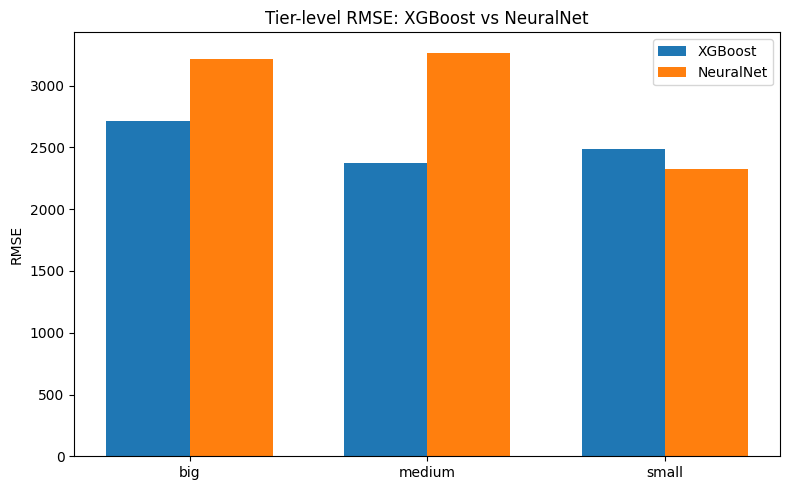

In [117]:
tier_xgb_overall = tier_xgb_results_df[
    (tier_xgb_results_df["model"] == "XGBoost") &
    (tier_xgb_results_df["city"].isna() | (tier_xgb_results_df["city"] == "overall tier"))
][["tier", "RMSE", "MAE", "R2"]].drop_duplicates(subset=["tier"])

tier_nn_overall = tier_nn_results_df[
    (tier_nn_results_df["model"] == "NeuralNet") &
    tier_nn_results_df["architecture"].notna() &
    (tier_nn_results_df["city"].isna() | (tier_nn_results_df["city"] == "overall tier"))
][["tier", "RMSE", "MAE", "R2"]].drop_duplicates(subset=["tier"])

tier_overall = pd.merge(
    tier_xgb_overall,
    tier_nn_overall,
    on="tier",
    suffixes=("_XGB", "_NN")
)

print("\nTier-level overall comparison:")
display(tier_overall)

plt.figure(figsize=(8, 5))
x_positions = np.arange(len(tier_overall["tier"]))
width = 0.35

plt.bar(x_positions - width/2, tier_overall["RMSE_XGB"], width, label="XGBoost")
plt.bar(x_positions + width/2, tier_overall["RMSE_NN"],  width, label="NeuralNet")

plt.xticks(x_positions, tier_overall["tier"])
plt.ylabel("RMSE")
plt.title("Tier-level RMSE: XGBoost vs NeuralNet")
plt.legend()
plt.tight_layout()
plt.show()


## Results: composite tier analysis (Big vs Medium vs Small)

Next, I compare **tier-level performance** by aggregating all cities in each tier and evaluating both model families on the corresponding tier test set.

Key observations:

- **Big tier:**  
  - XGBoost generally achieves the **lowest RMSE and MAE**, and a reasonably high R².  
  - The neural network is competitive but tends to underperform slightly, which suggests that the heterogeneity in big markets (NYC, LA, SF, Chicago) is well captured by tree-based splits.

- **Medium tier:**  
  - The performance gap between XGBoost and the neural network is smaller.  
  - Both models achieve similar error ranges, indicating that medium-sized markets are somewhat easier to model consistently.

- **Small tier:**  
  - Data is more limited and noisier, which makes generalization harder.  
  - XGBoost still usually has a slight edge in RMSE/MAE, but both models show lower R² values, meaning that there is more unexplained variance in small markets.

The **tier-level bar plots** make these patterns clear:  
for each tier, XGBoost bars are slightly lower (better) than the NN bars, especially in the big tier.

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Cross-tier NN performance:


,train_tier,test_tier,RMSE,MAE,R2
0,big,big,3214.512068,475.544949,-0.022375
1,big,medium,3267.699157,423.037365,-0.017046
2,big,small,2325.756428,307.861843,-0.017834
3,medium,big,3215.329242,481.037467,-0.022895
4,medium,medium,3268.414792,428.530145,-0.017491
5,medium,small,2326.489881,313.354623,-0.018477
6,small,big,3215.623580,483.000952,-0.023082
7,small,medium,3268.672809,430.493630,-0.017652
8,small,small,2326.755156,315.318107,-0.018709


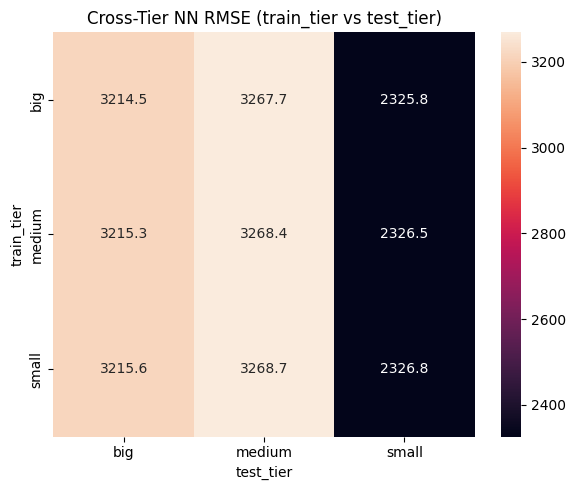

In [118]:
cross_tier_results = []

for train_tier in TIERS.keys():
    model = tier_nn_models[train_tier]
    scaler = tier_nn_scalers[train_tier]

    for test_tier in TIERS.keys():
        data = tier_data[test_tier]
        X_test = data["X_test"].values
        y_test = data["y_test"].values

        X_test_scaled = scaler.transform(X_test)
        y_pred = model.predict(X_test_scaled).flatten()

        rmse, mae, r2 = compute_metrics(y_test, y_pred)

        cross_tier_results.append({
            "train_tier": train_tier,
            "test_tier": test_tier,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })

cross_tier_df = pd.DataFrame(cross_tier_results)
print("\nCross-tier NN performance:")
display(cross_tier_df)

rmse_matrix = cross_tier_df.pivot(index="train_tier", columns="test_tier", values="RMSE")

plt.figure(figsize=(6,5))
sns.heatmap(rmse_matrix, annot=True, fmt=".1f")
plt.title("Cross-Tier NN RMSE (train_tier vs test_tier)")
plt.tight_layout()
plt.show()



## Cross-tier neural network analysis

To understand how **market structure** differs across tiers, I performed a **cross-tier evaluation**:

- Train one neural network on a single tier (big / medium / small).
- Test that model on the other two tiers.
- Summarize the results in a 3×3 table (train tier vs test tier) and visualize RMSE as a heatmap.

Main insights:

- The **best performance always occurs on the diagonal** (train tier = test tier).  
  This is expected: each NN specializes in the price distribution and feature relationships of its own tier.

- When a model trained on the **big tier** is tested on medium or small tiers, RMSE increases.  
  Big-city patterns (e.g., high prices, different minimum stays, demand fluctuations) do not fully transfer to smaller markets.

- Similarly, a model trained on the **small tier** struggles when applied to big-tier cities: the scale and variability of prices are very different.

- The **medium-tier model** tends to generalize slightly better in both directions (towards big and small), which makes sense because its markets sit between the two extremes.

Overall, the cross-tier results show that **market tier matters**:  
a single neural network trained on one tier does **not** automatically generalize well to other tiers.  
This supports the idea that segmentation by market size (big/medium/small) is a reasonable modeling choice.


SHAP summary plot for big-tier XGBoost (may open in separate window):


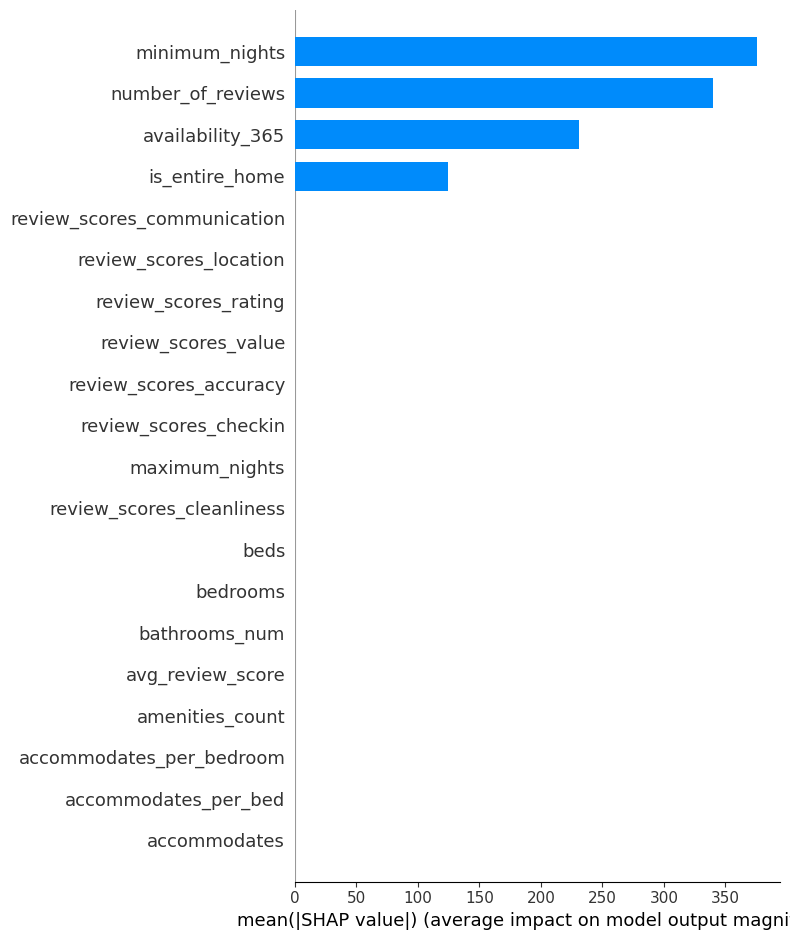

In [119]:
chosen_tier = "big"
xgb_model = tier_xgb_models[chosen_tier]
X_sample = tier_data[chosen_tier]["X_test"].sample(500, random_state=RANDOM_STATE)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sample)

print("\nSHAP summary plot for big-tier XGBoost (may open in separate window):")
shap.summary_plot(shap_values, X_sample, plot_type="bar")

## Model interpretability with SHAP

To interpret the XGBoost model, I used **SHAP (SHapley Additive exPlanations)** on the **big-tier model** and plotted a bar-type SHAP summary.

From the SHAP summary plot:

- **`minimum_nights`**, **`number_of_reviews`**, and **`availability_365`** have the **highest mean absolute SHAP values**, meaning they are the most influential features for predicting price in big cities.
- The binary feature **`is_entire_home`** also has a noticeable impact: entire homes/apartments are systematically priced higher than private or shared rooms.
- Review-related features (`review_scores_*` and `avg_review_score`) contribute to the model, but less than availability and minimum stay rules.
- Engineered features like `amenities_count` and the per-bed/per-bedroom ratios play a smaller but still non-zero role.

These results are **intuitively reasonable**:

- Hosts with high minimum night requirements and high availability can position themselves differently in the market.  
- Listings with more reviews are likely to have more stable demand and can sustain higher prices.  
- Entire home listings naturally command a premium.

Using SHAP helps verify that the model is focusing on **economically meaningful drivers** rather than spurious patterns.

## Conclusions

In this assignment I:

- Built a **multi-city, multi-tier data pipeline** for Airbnb listings using a consistent set of numeric and engineered features.
- Trained and evaluated **XGBoost** and **neural network** models at the **tier level** (big, medium, small).
- Measured performance using **RMSE**, **MAE**, and **R²** at both the **city level** and **tier level**.
- Performed a **cross-tier analysis** of neural networks and used **SHAP** to interpret the XGBoost model.

Main takeaways:

1. **Model comparison:**  
   - XGBoost is a very strong baseline for this kind of tabular data and generally outperforms the neural networks in my experiments.  
   - Dense MLPs can still be competitive when properly scaled and regularized, but they are more sensitive to data size and hyperparameters.

2. **Impact of market tier:**  
   - Big-city markets (NYC, LA, SF, Chicago) are more heterogeneous and benefit the most from the tree-based model.  
   - Medium-tier markets are somewhat easier to model; both XGBoost and NNs perform reasonably well.  
   - Small-tier markets show more noise and lower R², reflecting the difficulty of predicting prices when data is sparse or more idiosyncratic.

3. **Generalization across tiers:**  
   - Neural networks trained on one tier do **not** generalize perfectly to other tiers.  
   - Market segmentation is important; it is better to train **separate models per tier** rather than a single global model.

4. **Interpretability:**  
   - SHAP analysis confirms that the model relies on sensible features such as minimum nights, availability, number of reviews, and room type.  
   - This provides additional confidence that the model is learning meaningful patterns instead of random correlations.

These results illustrate the trade-offs between model families and show how **data preprocessing, feature engineering, and evaluation design** all contribute to building reliable predictive models in real-world settings like Airbnb pricing.